In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
kb = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

from misloc_mispol_package.parameterize import displaced_osc_model as dom


In [2]:
## This needs to be in a seperate cell from the imports
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 300,  # to adjust notebook inline plot size
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
#     'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4, 3], # 4 x 3
    'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)


In [3]:
test_script_d = 1.5

In [4]:
dom.invcmtohz(2500)*hbar

0.30996049346900717

In [5]:
dom.invcmtohz(600)*hbar

0.07439051843256171

In [6]:
def sig_prime(omega, t): 
    return np.real(np.exp(1j*(omega)*t*1e-15 - dom.g(t, test_script_d)))

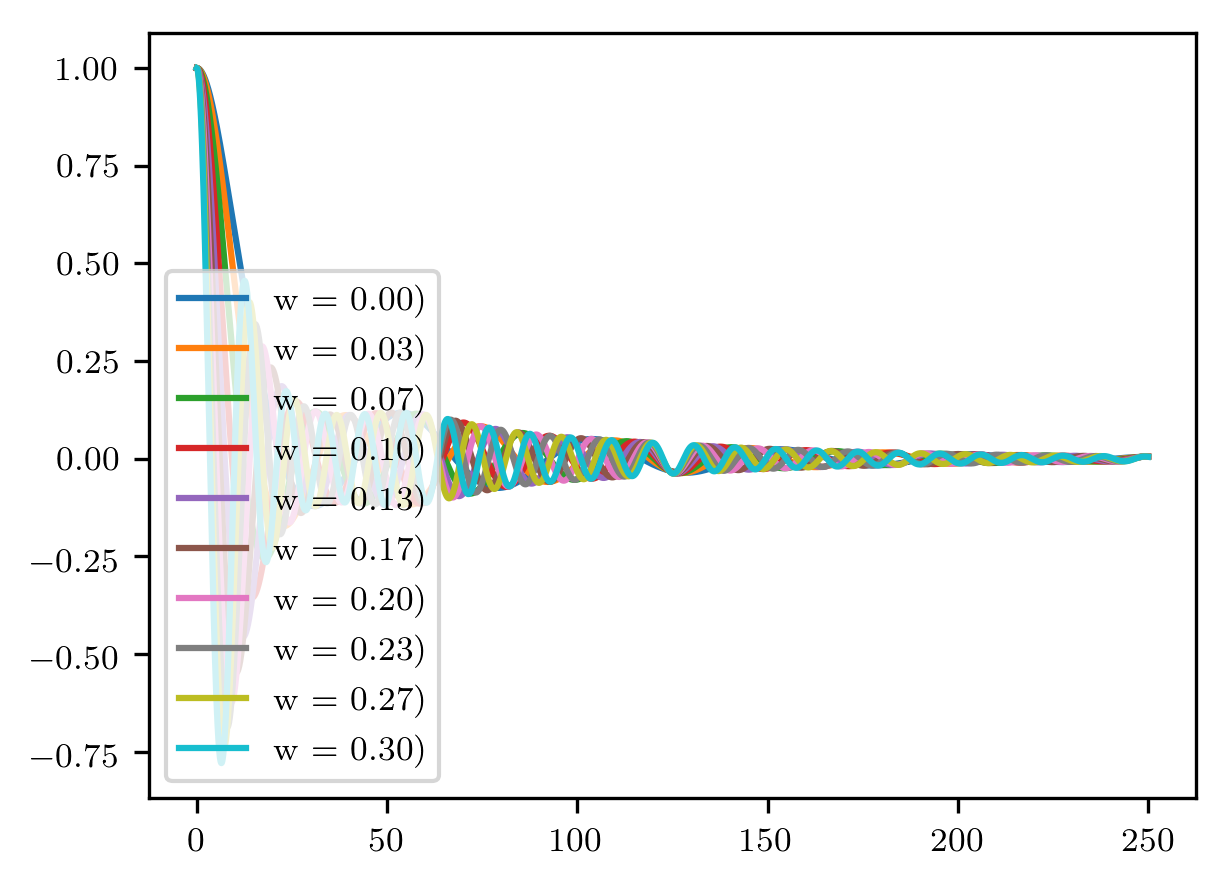

In [7]:
omegas = np.linspace(0, .3/hbar, 10)
time_points = 10000
t_bound = 250
for w in omegas:
    plt.plot(
        np.linspace(0, t_bound, time_points), 
        sig_prime(w, np.linspace(0, t_bound, time_points)),
        label=f'w = {(hbar*w):.2f})'
        )
#     plt.xlim([0,.1])
        
plt.legend()

In [8]:
(np.ones(10,)[:,None] * np.ones(100)).shape

(10, 100)

In [9]:
(np.ones(10,)[:,None] * np.ones(100)).sum(axis=-1)

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.])

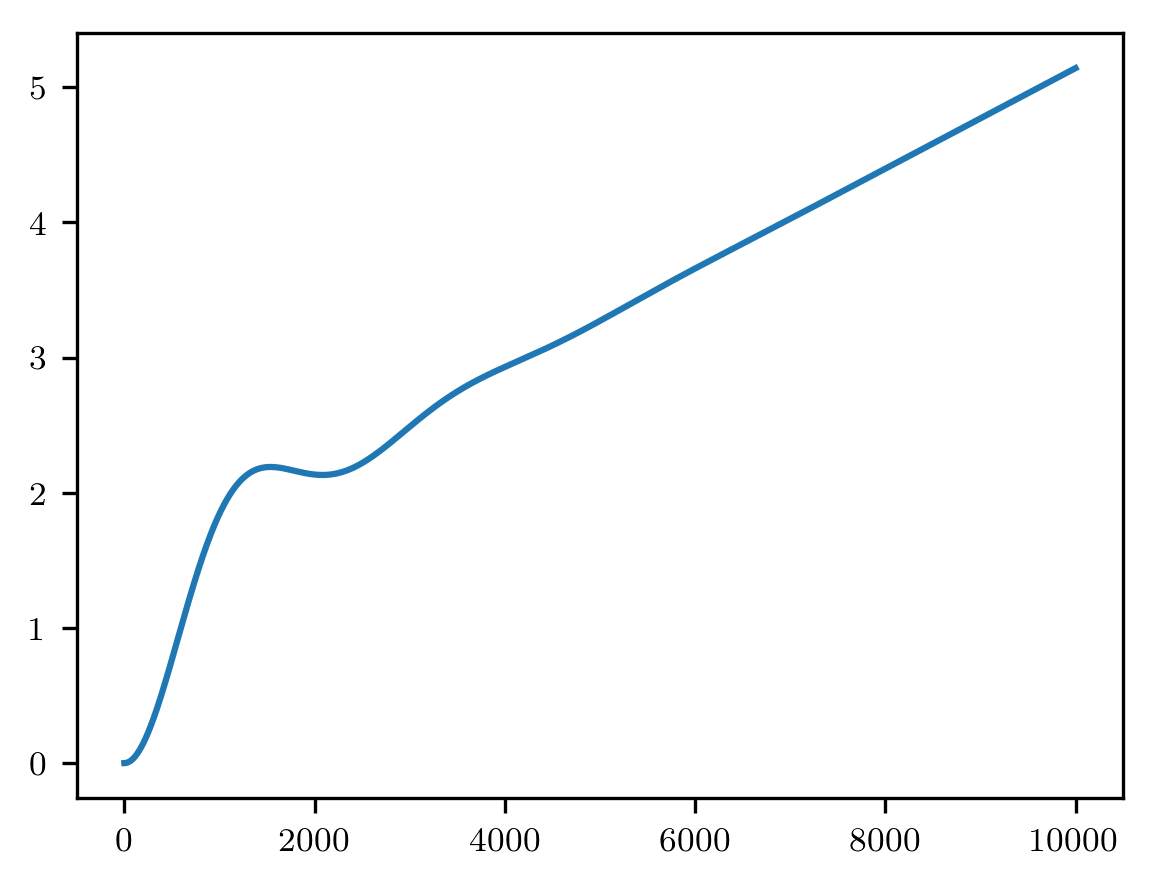

In [10]:
plt.plot(np.real(dom.g(np.linspace(0, t_bound, time_points), test_script_d)))

In [11]:
omegas

array([0.00000000e+00, 5.06422487e+13, 1.01284497e+14, 1.51926746e+14,
       2.02568995e+14, 2.53211243e+14, 3.03853492e+14, 3.54495741e+14,
       4.05137990e+14, 4.55780238e+14])

In [12]:
sig_prime(omegas[1], 1)

array([0.99244859])

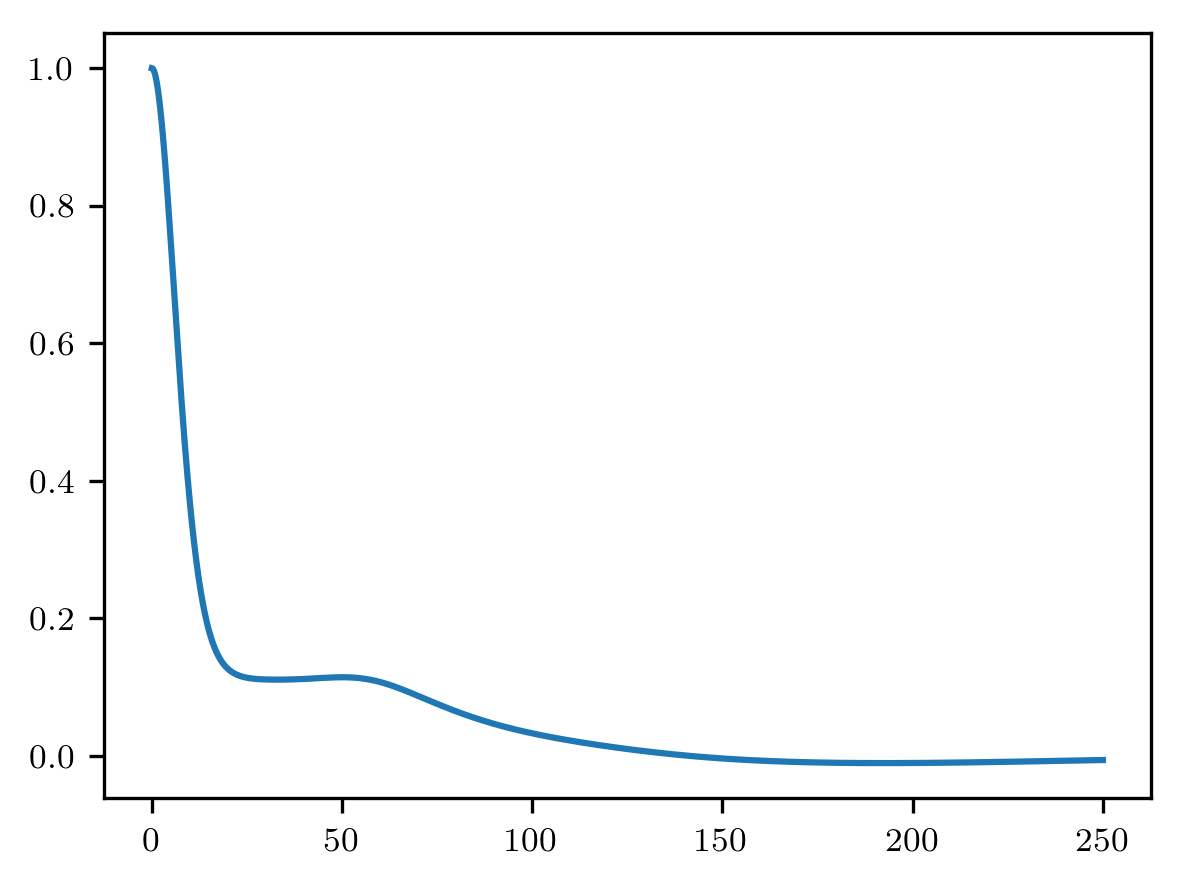

In [13]:
plt.plot(
    np.linspace(0, t_bound, time_points), 
    sig_prime(.12-1/2*1.4**2.*dom.invcmtohz(600), np.linspace(0, t_bound, time_points)),
#     label=f'w = {(hbar*w):.2f})'
    )

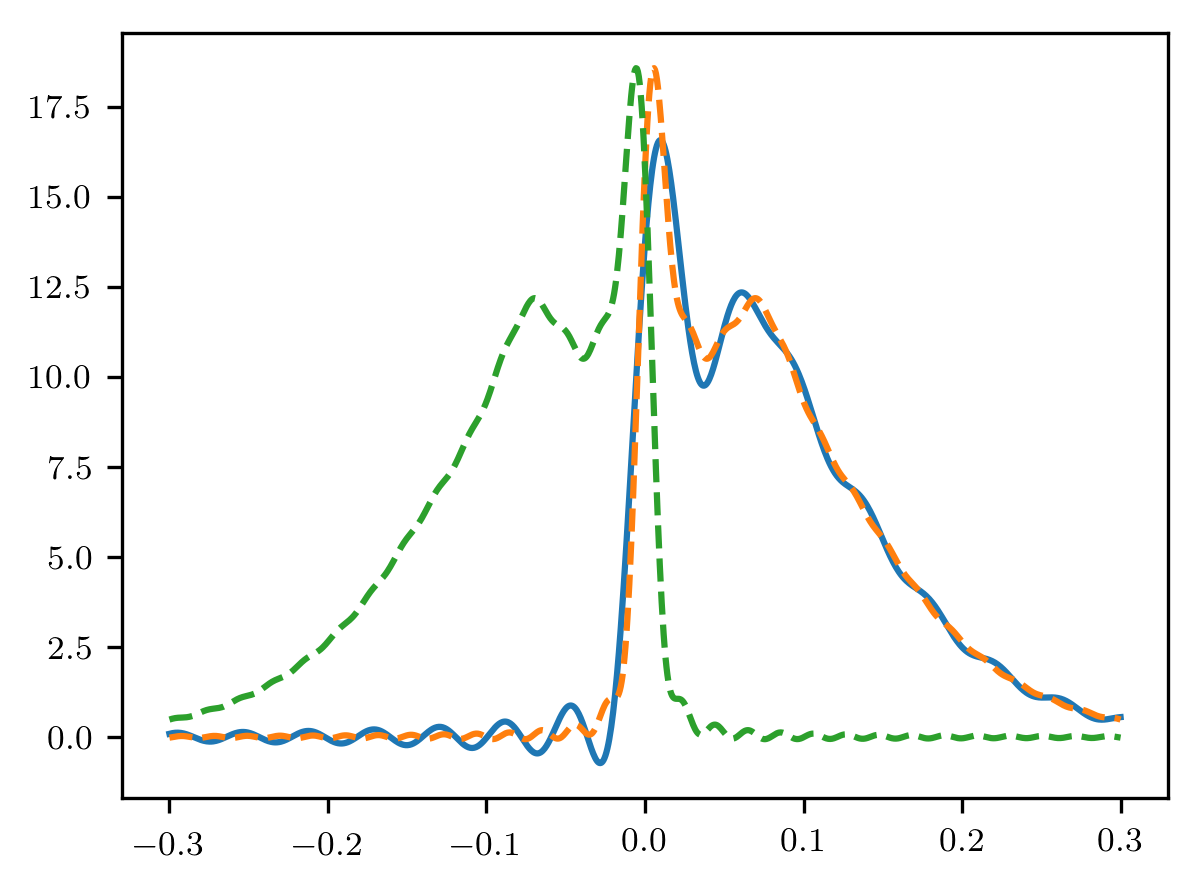

In [14]:
omegas = np.linspace(-.3/hbar,.3/hbar, 1000)
plt.plot(
    hbar*omegas, 
    dom.sigma_a(
        (omegas-(1/2*test_script_d**2.*dom.invcmtohz(600))), 
        test_script_d,
        t_bound=100, 
        t_points=1000))
plt.plot(
    hbar*omegas, 
    dom.sigma_a(
        (omegas-(1/2*test_script_d**2.*dom.invcmtohz(600))), 
        test_script_d,
#         omega_q=dom.invcmtohz(600),
#         gamma=dom.invcmtohz(400),
        t_bound=200, 
        t_points=1000
        ),
    ls='--'
    )

plt.plot(
    hbar*omegas, 
    dom.sigma_e(
        (omegas-(1/2*test_script_d**2.*dom.invcmtohz(600))), 
        test_script_d, 
#         omega_q=dom.invcmtohz(600),
#         gamma=dom.invcmtohz(400),
        t_bound=200, 
        t_points=1000
        ),
    ls='--'
    )
# plt.xlim([-.1, 0])

In [13]:
int.trapz(
    dom.sigma_a(
        (omegas-(1/2*test_script_d**2.*dom.invcmtohz(600))), 
        test_script_d,
        t_bound=200, 
        t_points=10000
        ),
    hbar*omegas
#     omegas
    )



2.066077320272382

In [14]:
1000*np.pi*2*c *hbar

0.12398419738760286

Integrating this thing is going to be tricky.

For a frequency of .3/hbar, the period is...

In [15]:
2*np.pi/(.3/hbar)

1.3785558873488278e-14

Might need a flexible integration routine for the fitting routine. I am not sure that picking a fixed interval is ideal, but it seems to elimiate a for loop.

Let's load the data and try fitting.

Text(0.5, 0, 'Photon Energy $\\hbar\\omega$ [eV]')

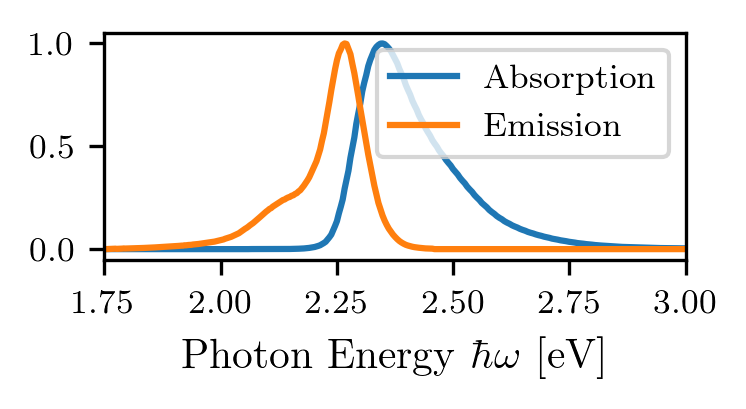

In [16]:
path_to_mol_data = (
    "/Users/chair/Documents/Academia/SuperRes/Biteen_colab/"+
    "Mispolarization/python/gitted/spectral_fitting/")

# R6G_spectrum = sio.loadmat(os.path.join(path_to_mol_data, "R6G_spectrum.mat"))
thermo_fisher_dye_data = np.loadtxt(
    os.path.join(path_to_mol_data, 'BODIPY R6G.csv'), 
    skiprows=1, 
    delimiter=','
    )
# R6G_spectrum.keys()
max_excitation_wavelength = thermo_fisher_dye_data.T[0][np.argmax(thermo_fisher_dye_data.T[1])]
max_excitation_wavelength
plt.figure(dpi=300, figsize=(2.5,1))
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorption')
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emission')
plt.legend()
plt.xlim([1.75, 3])
plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)

# R6G_emis = R6G_spectrum["bdpr6g"]
# # R6G_spectrum.shape

# # R6G_spectrum[1,:5]
# # plt.figure(dpi=150)
# plt.plot(1240/R6G_emis[0], R6G_emis[1])
# plt.title('R6G Emission from Curly')
# plt.xlabel('eV')

Build the fit function to the normalized emission spectrum

In [17]:
%%time
a = dom.sigma_a(
    (omegas-(1/2*test_script_d**2.*dom.invcmtohz(600))), 
    test_script_d,
    t_bound=100, 
    t_points=10000)

CPU times: user 895 ms, sys: 365 ms, total: 1.26 s
Wall time: 1.31 s


In [18]:
ini_guess_model_fit = [2.35, 2, dom.invcmtohz(600)*hbar, dom.invcmtohz(400)*hbar, 350]

model_fit = opt.least_squares(
    dom.muk_mol_fit_fun,
    x0=ini_guess_model_fit,
    args=tuple((1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2])),
    )

/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/misloc_mispol_package/parameterize/displaced_osc_model.py:217: RuntimeWarning: overflow encountered in exp
  return (np.exp(-p*t) + p*t - 1)/p**2.
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/misloc_mispol_package/parameterize/displaced_osc_model.py:217: RuntimeWarning: invalid value encountered in true_divide
  return (np.exp(-p*t) + p*t - 1)/p**2.
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/misloc_mispol_package/parameterize/displaced_osc_model.py:256: RuntimeWarning: overflow encountered in multiply
  last_term
/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/misloc_mispol_package/parameteri

In [19]:
model_fit.x

array([2.53916256e+00, 2.06010150e+00, 1.28481102e-01, 4.96524743e-02,
       3.50000057e+02])

In [20]:
# model_fit

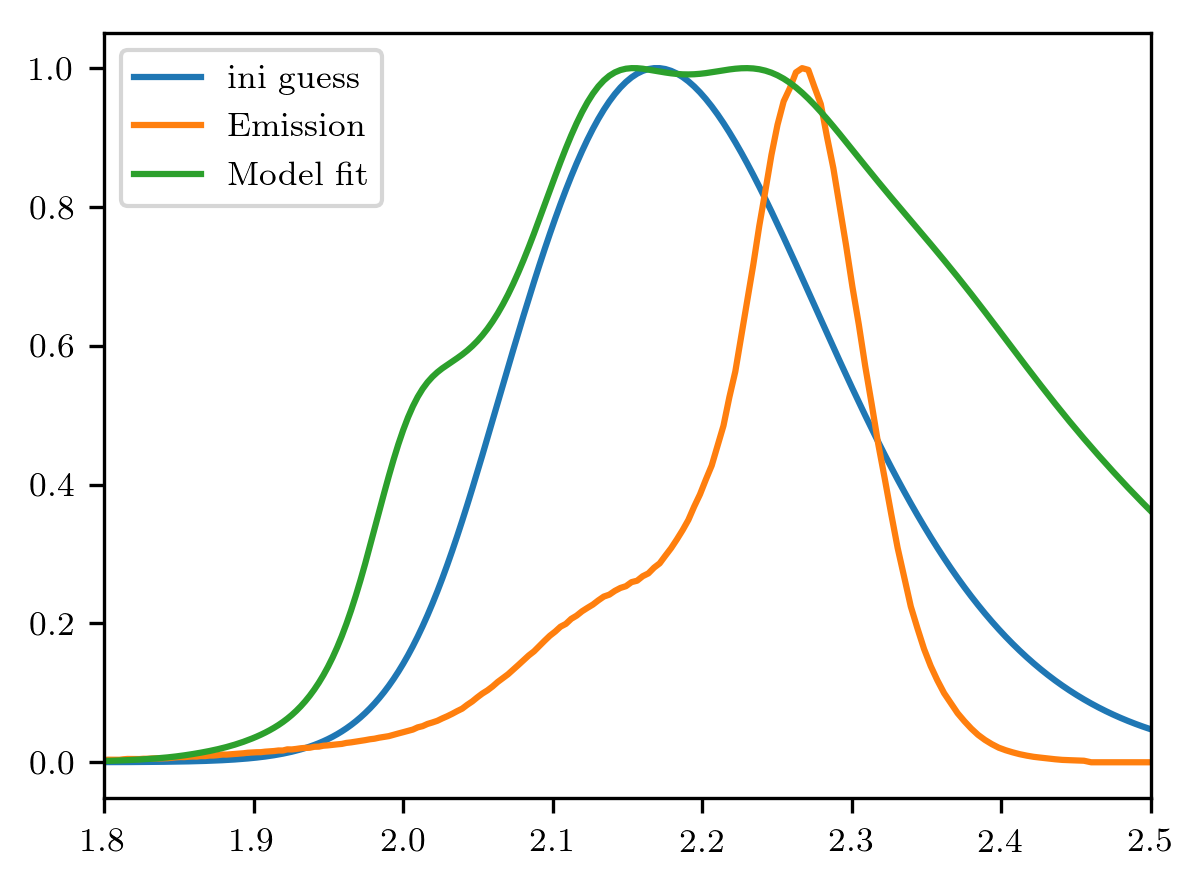

In [21]:
def normed_model(hbar_omegas, params):
    
    result = (
        dom.muk_mol_model(hbar_omegas, *params) 
        / 
        np.max(dom.muk_mol_model(hbar_omegas, *params) )
        )
    
    return result 

normed_model_fit = (
    normed_model(1240/thermo_fisher_dye_data.T[0], model_fit.x)
    )
    
initial_guess_spec = normed_model(1240/thermo_fisher_dye_data.T[0], ini_guess_model_fit)

plt.plot(1240/thermo_fisher_dye_data.T[0], initial_guess_spec, label='ini guess')

plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emission')

plt.plot(1240/thermo_fisher_dye_data.T[0], normed_model_fit, label='Model fit')

plt.xlim([1.8,2.5])
plt.legend()

I think I am trying to fit absorption to emission...

Need to look around for a better initial guess

In [22]:
dom.invcmtohz(600)*hbar

0.07439051843256171

In [23]:
dom.invcmtohz(40)*hbar

0.0049593678955041146

(1.5, 2.7)

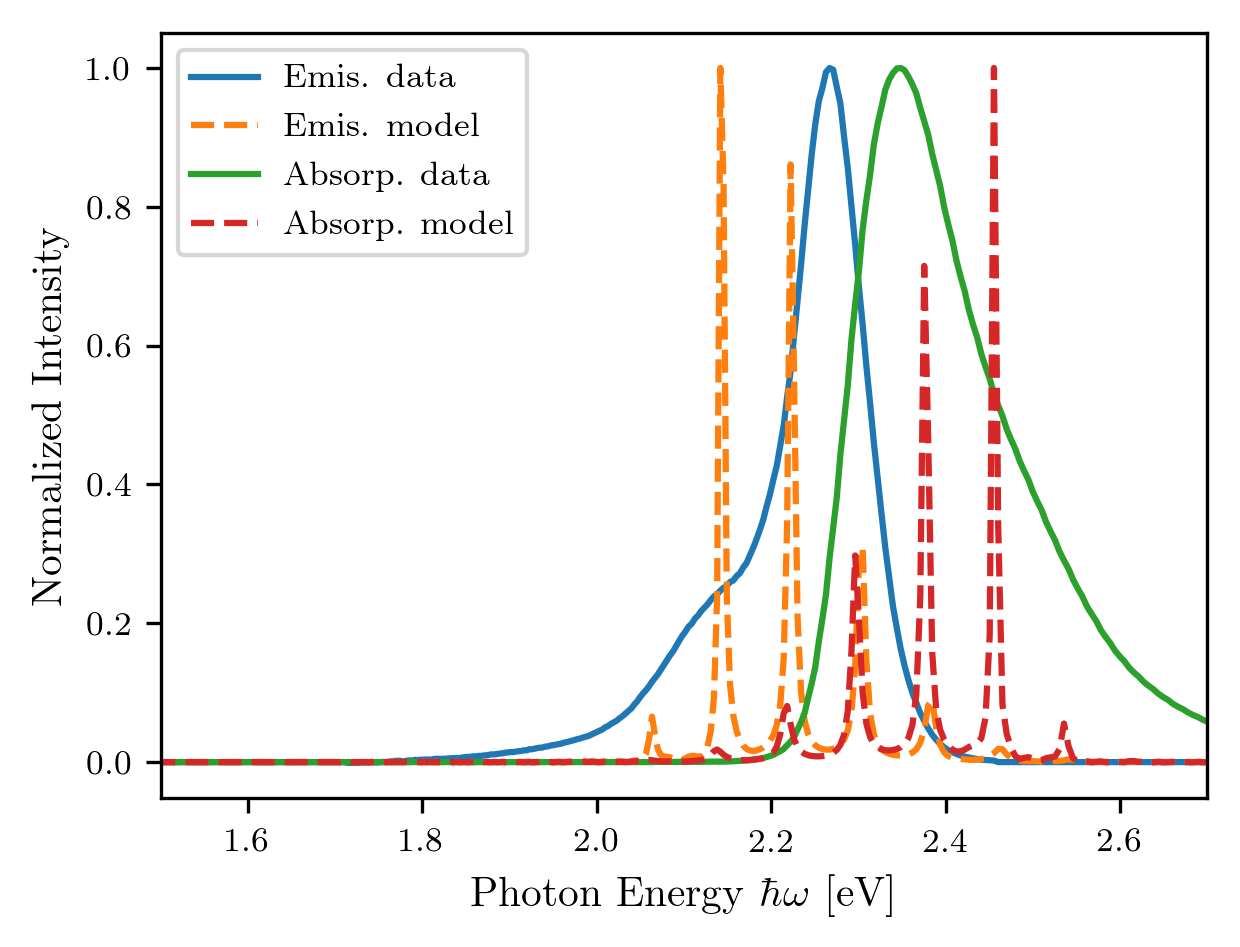

In [24]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.4
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .08
test_hbar_gamma = .003
test_t_bound = 1000
test_t_points = 10000
test_T = 350

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.5,2.7])

(1.8, 2.7)

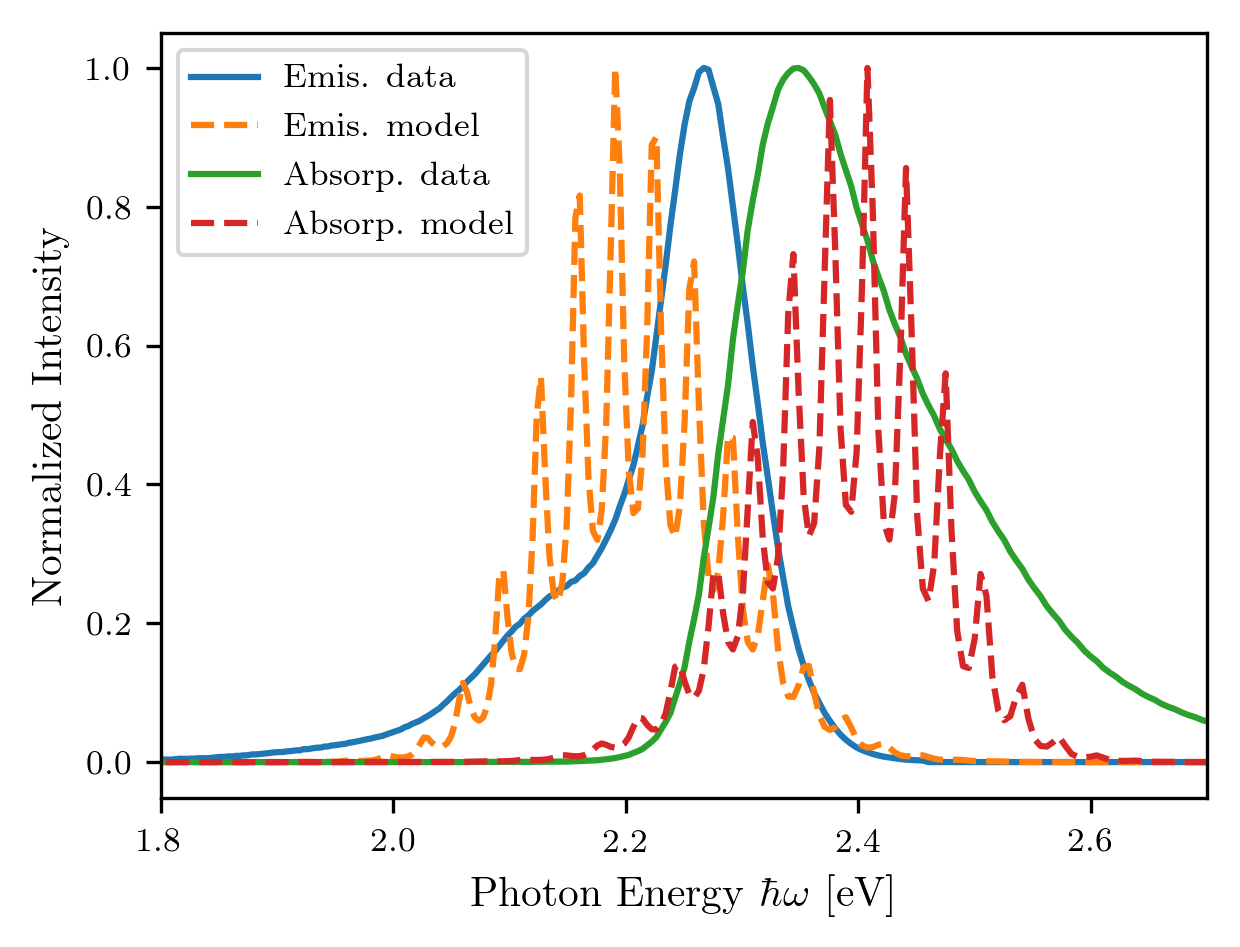

In [25]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 2.3
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .033
test_hbar_gamma = .001
test_t_bound = 1000
test_t_points = 10000
test_T = 350

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.8,2.7])

(1.8, 2.7)

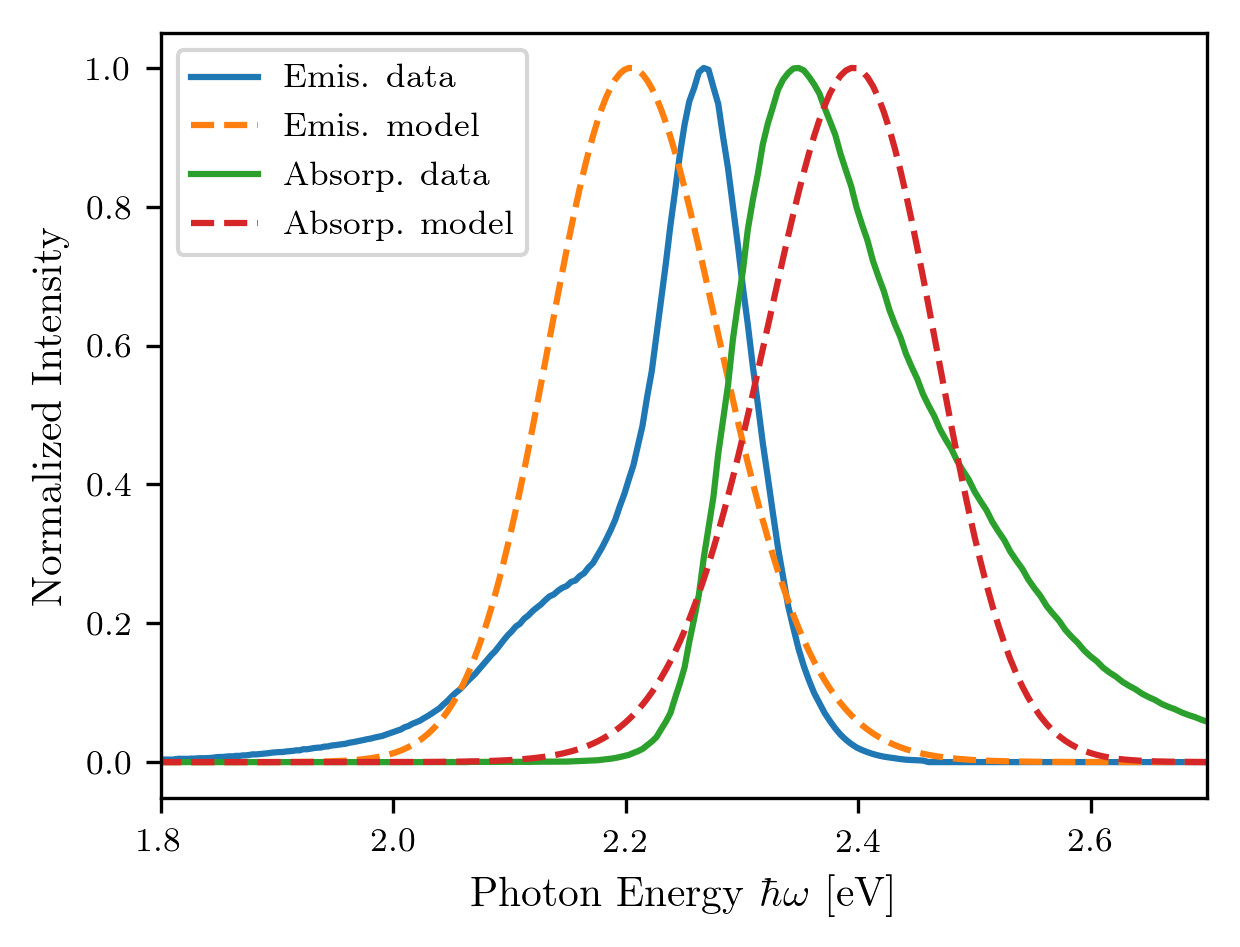

In [26]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 2.3
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .033
test_hbar_gamma = .01
test_t_bound = 1000
test_t_points = 10000
test_T = 350

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.8,2.7])

(1.8, 2.7)

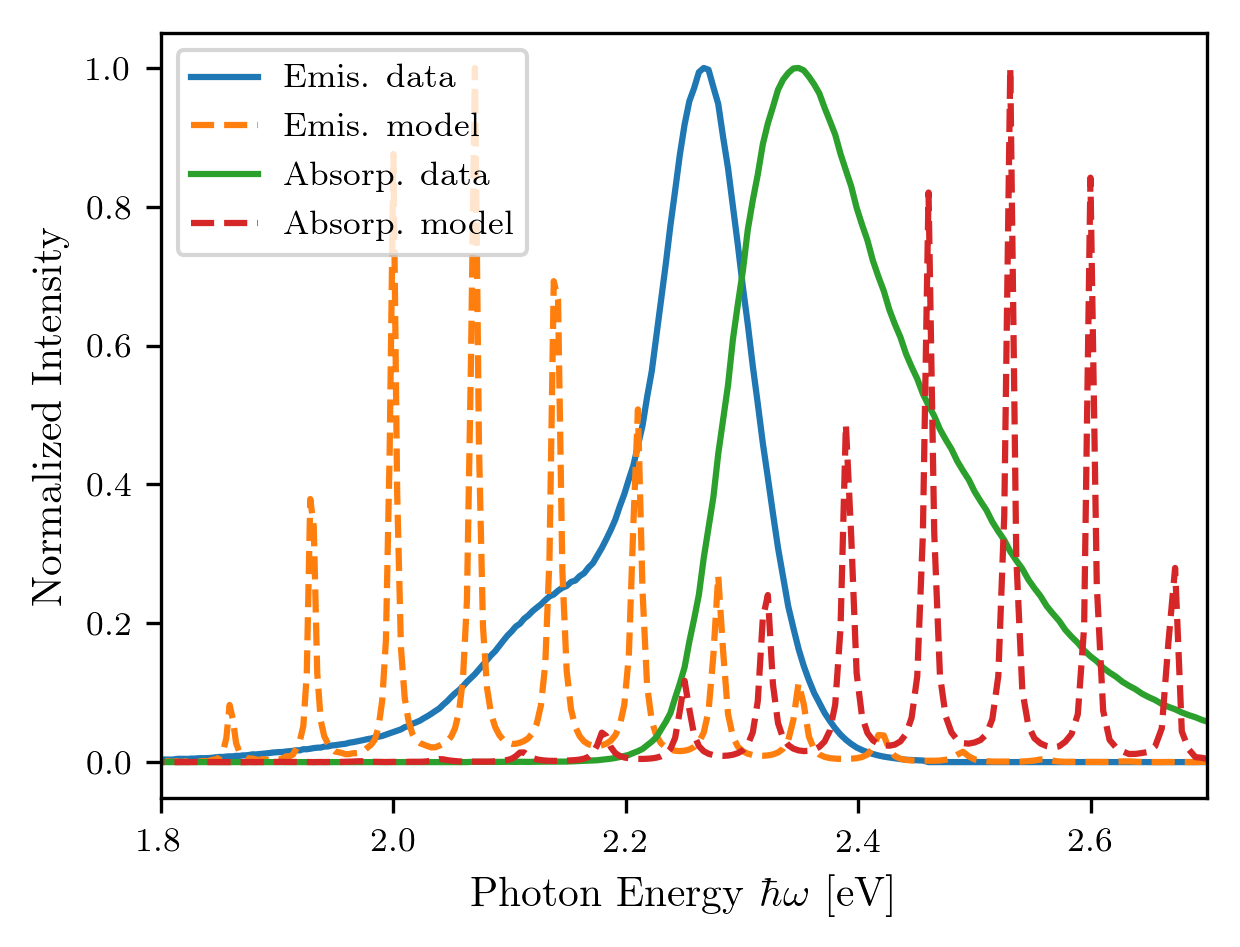

In [27]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 2.3
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .07
test_hbar_gamma = .001
test_t_bound = 1000
test_t_points = 10000
test_T = 350

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.8,2.7])

(1.8, 2.7)

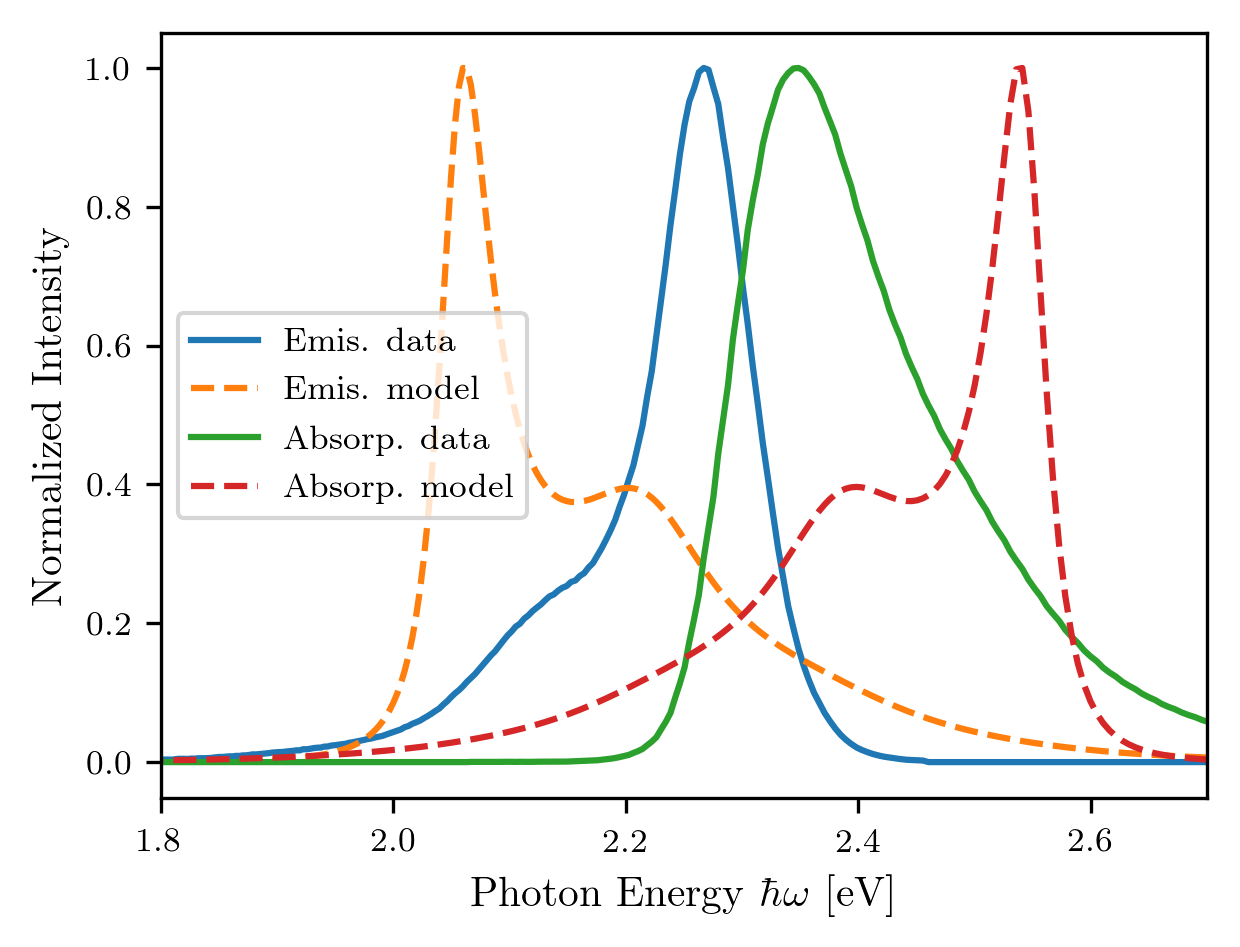

In [28]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.2
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .17
test_hbar_gamma = .1
test_t_bound = 1000
test_t_points = 10000
test_T = 350

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.8,2.7])

(1.8, 2.7)

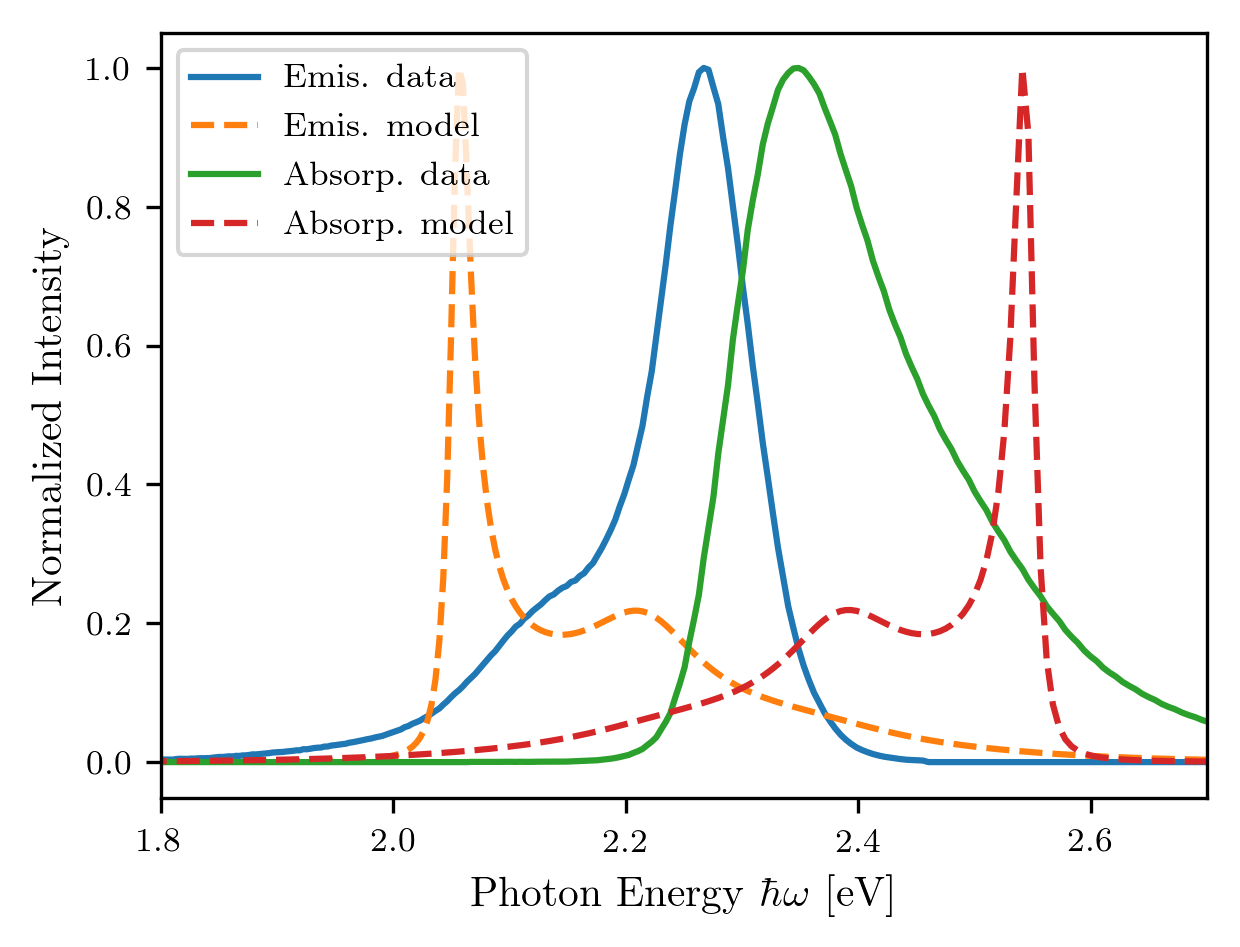

In [29]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.2
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .17
test_hbar_gamma = .1
test_t_bound = 1000
test_t_points = 10000
test_T = 100

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.8,2.7])

(1.8, 2.7)

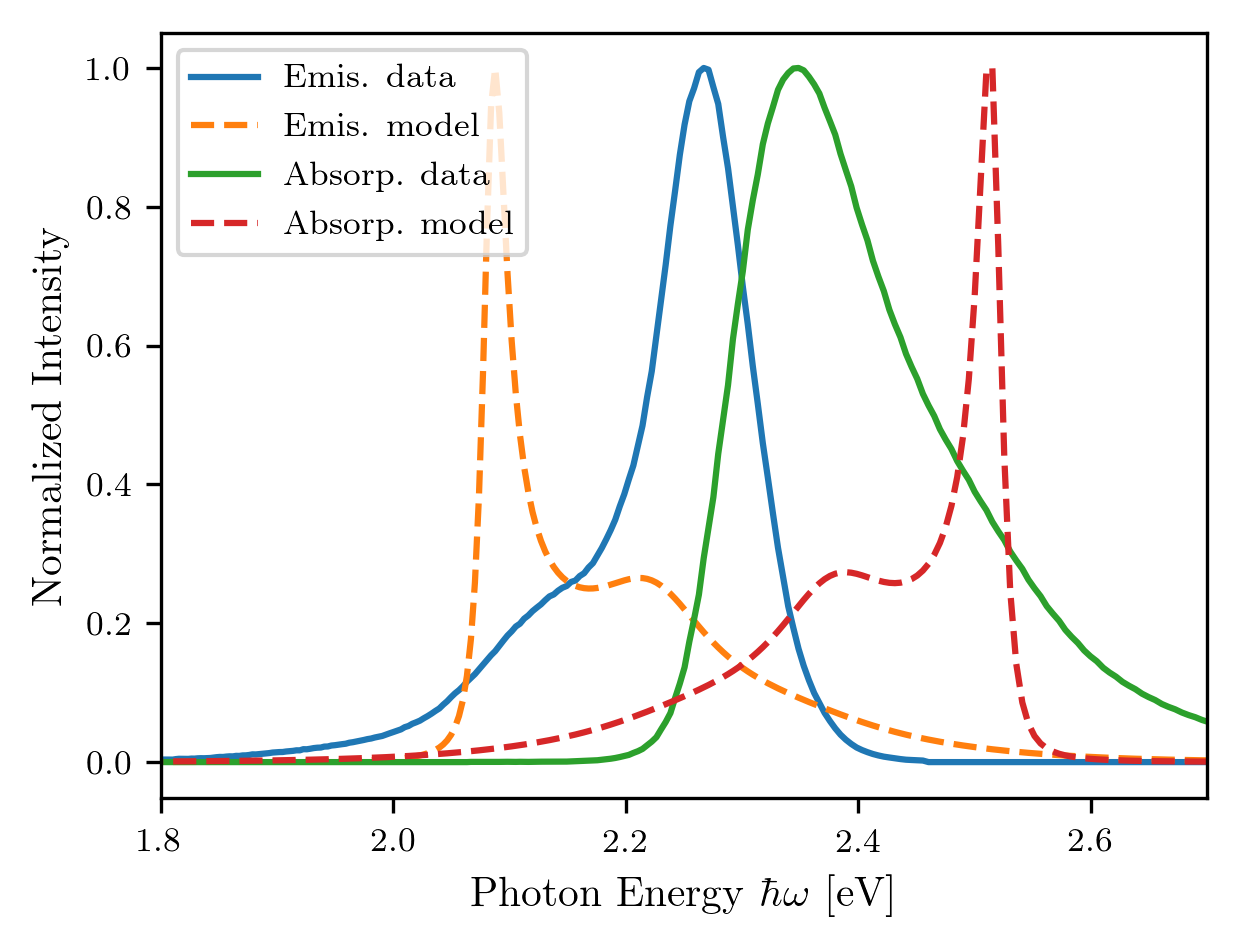

In [30]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.2
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .15
test_hbar_gamma = .1
test_t_bound = 1000
test_t_points = 10000
test_T = 100

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.8,2.7])

In [31]:
hbar*dom.invcmtohz(600)

0.07439051843256171

In [32]:
hbar*dom.invcmtohz(40)

0.0049593678955041146

(1.8, 2.7)

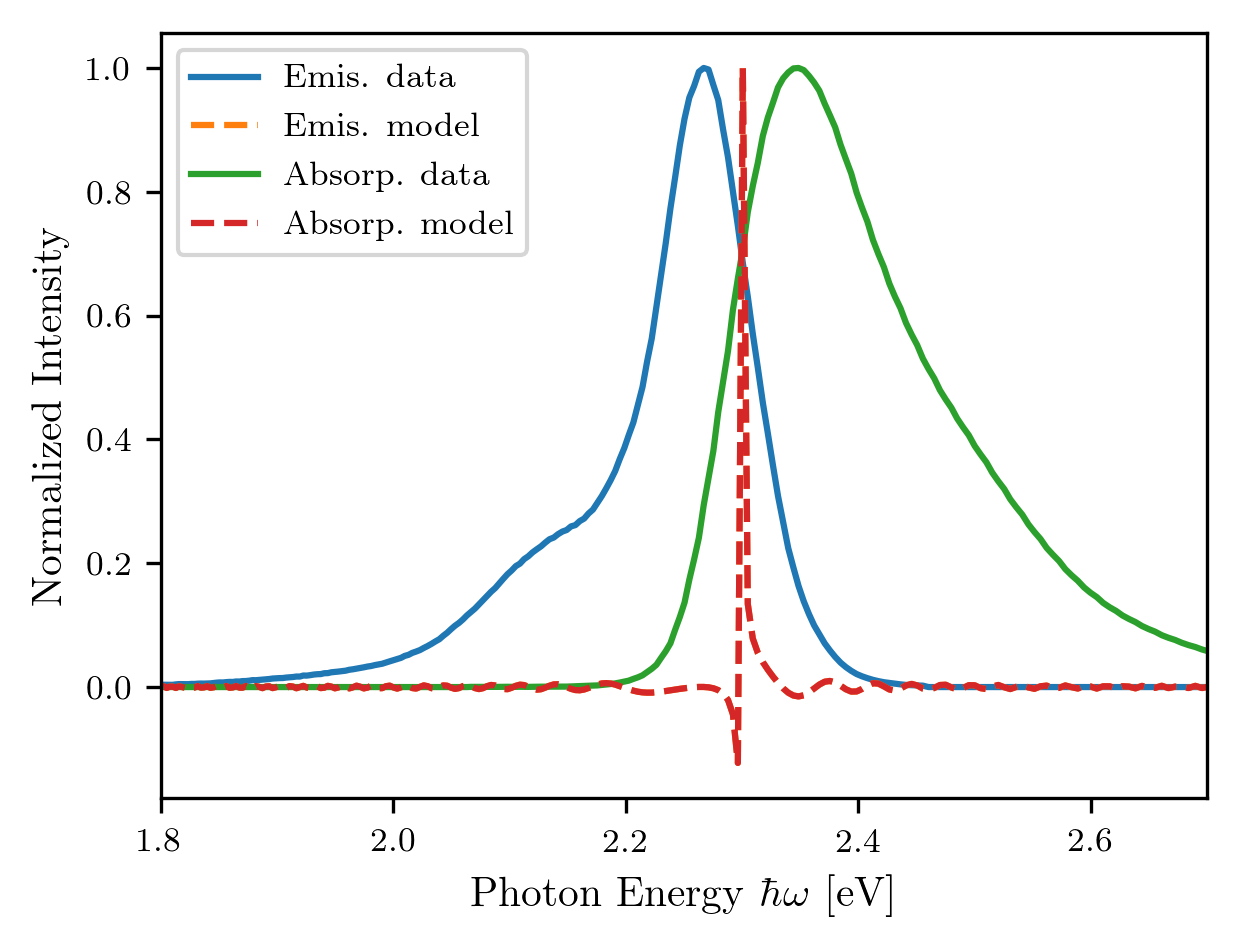

In [33]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 0
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = 0.074
test_hbar_gamma = 0.0049593
test_t_bound = 1000
test_t_points = 10000
test_T = 350

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.8,2.7])

(1.8, 2.7)

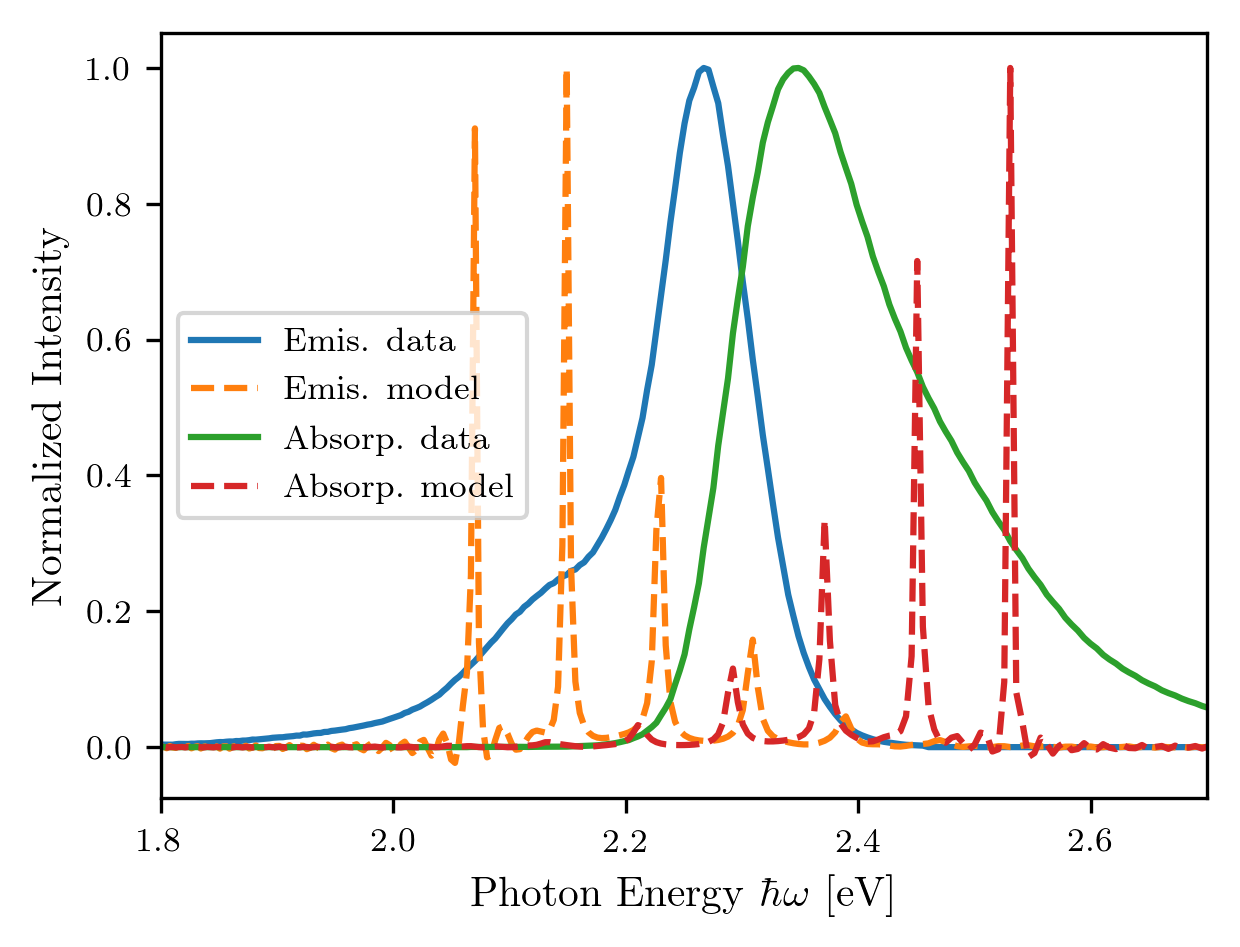

In [34]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.7
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .08
test_hbar_gamma = .003
test_t_bound = 1000
test_t_points = 10000
test_T = 10

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.8,2.7])

In [35]:
# test_hbar_omega_eg_0 = 2.3
# test_script_d = 2.3
# test_hbar_omega_0 = .033
# test_hbar_gamma = .01
# test_t_bound = 1000
# test_t_points = 1000
# test_T = 350

ini_guess_model_fit = [2.3, 2.3, .033, .01, 250]

model_fit = opt.least_squares(
    dom.muk_mol_fit_fun,
    x0=ini_guess_model_fit,
    args=tuple((1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2])),
    )

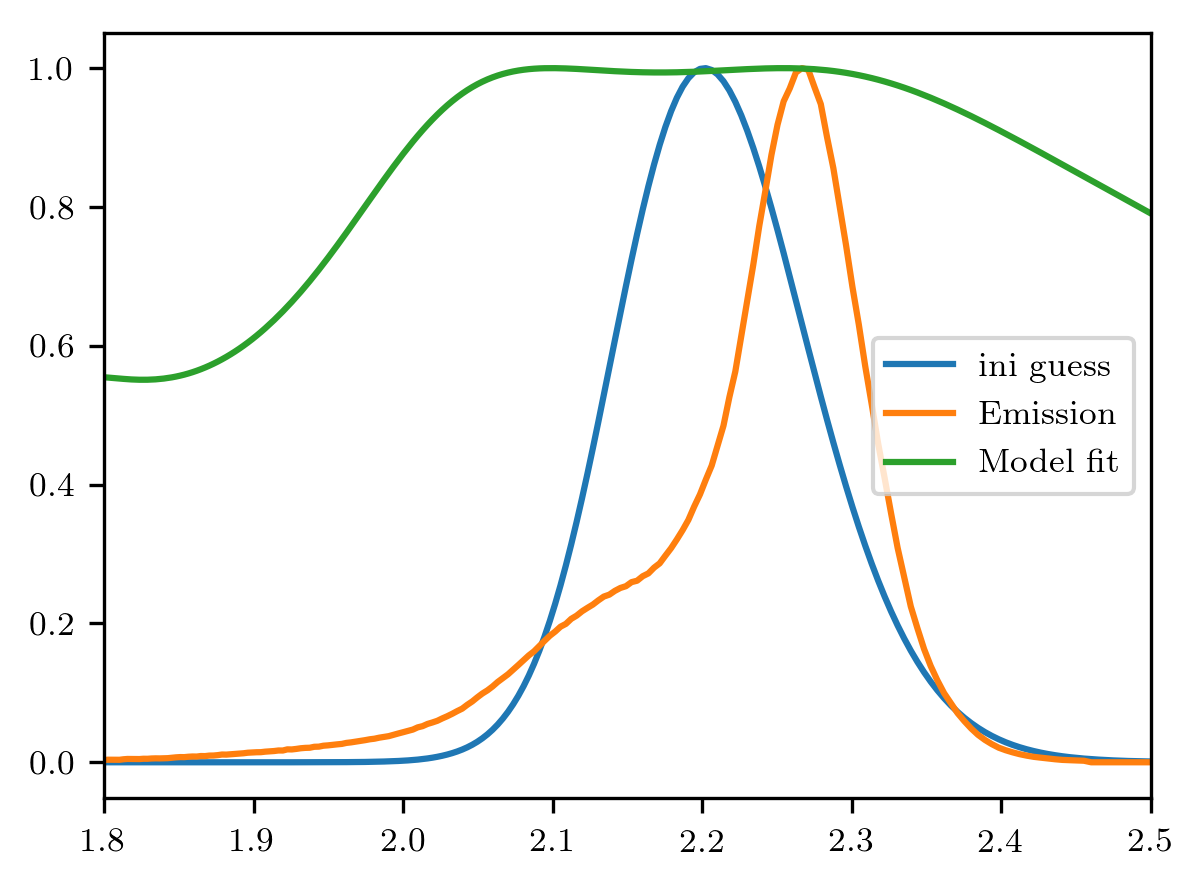

In [36]:
normed_model_fit = (
    normed_model(1240/thermo_fisher_dye_data.T[0], model_fit.x)
    )
    
initial_guess_spec = normed_model(1240/thermo_fisher_dye_data.T[0], ini_guess_model_fit)

plt.plot(1240/thermo_fisher_dye_data.T[0], initial_guess_spec, label='ini guess')

plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emission')

plt.plot(1240/thermo_fisher_dye_data.T[0], normed_model_fit, label='Model fit')

plt.xlim([1.8,2.5])
plt.legend()

## Let's try again to get something looking like the mukamel figs

Start with small damping

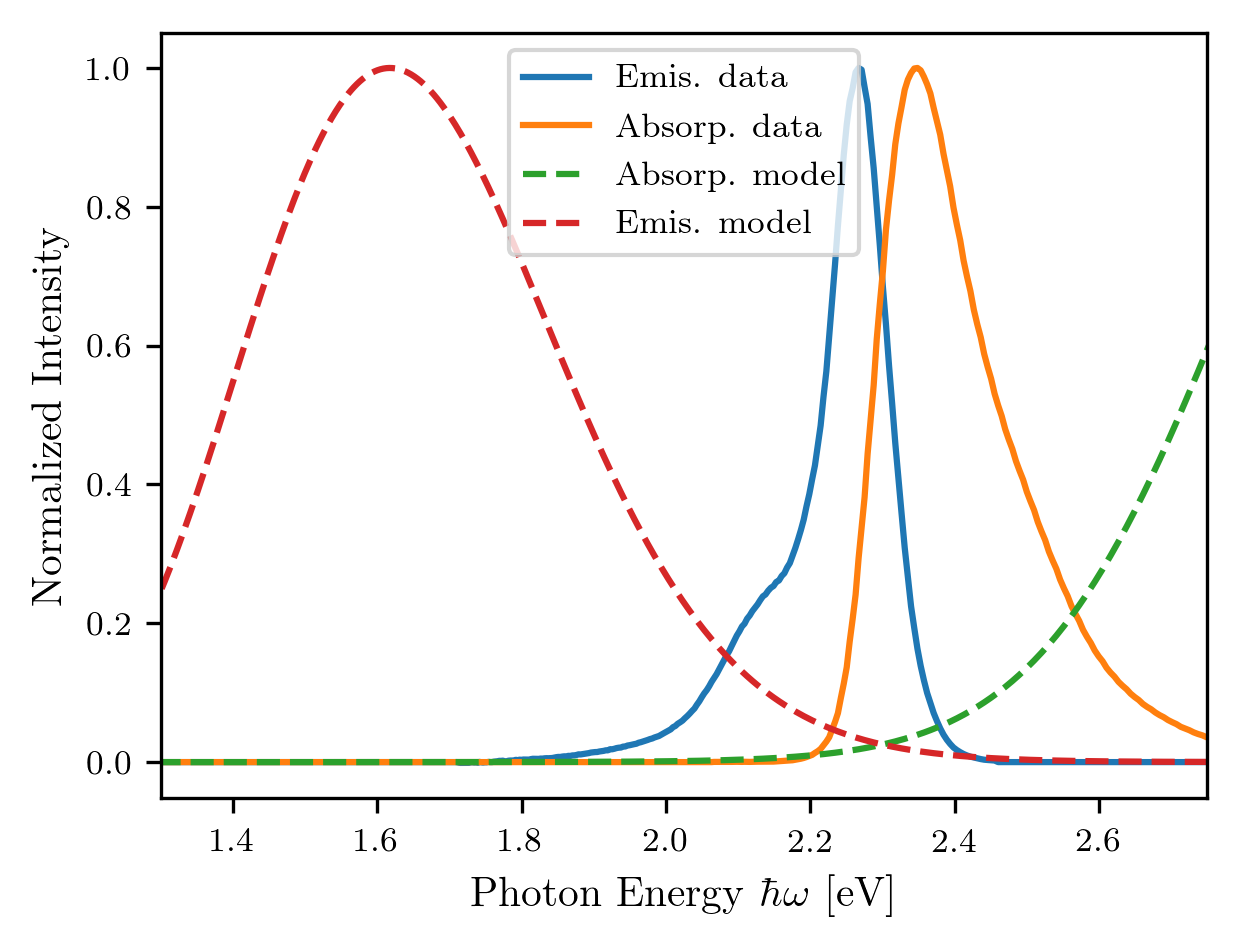

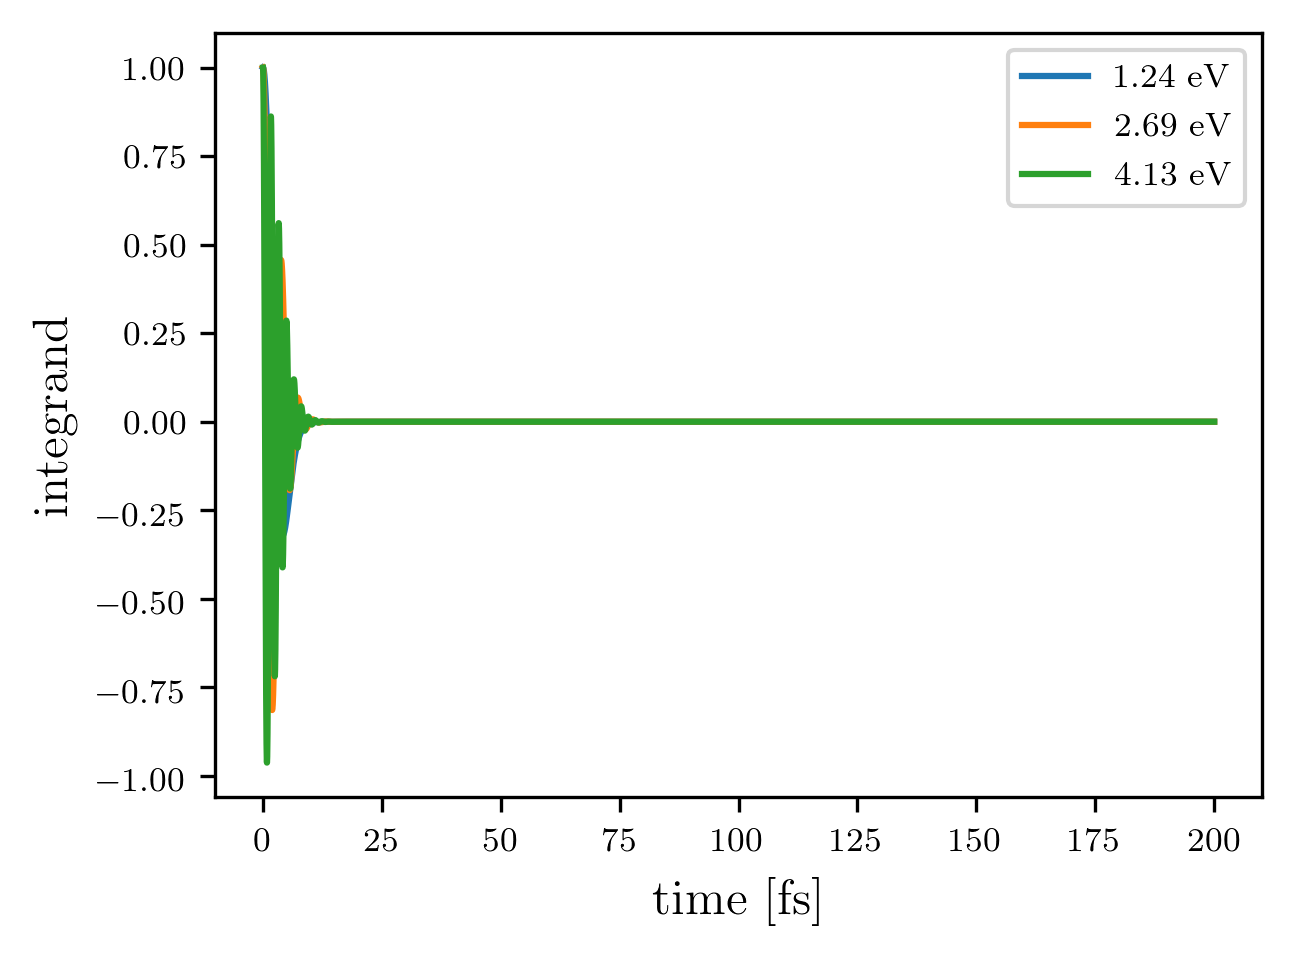

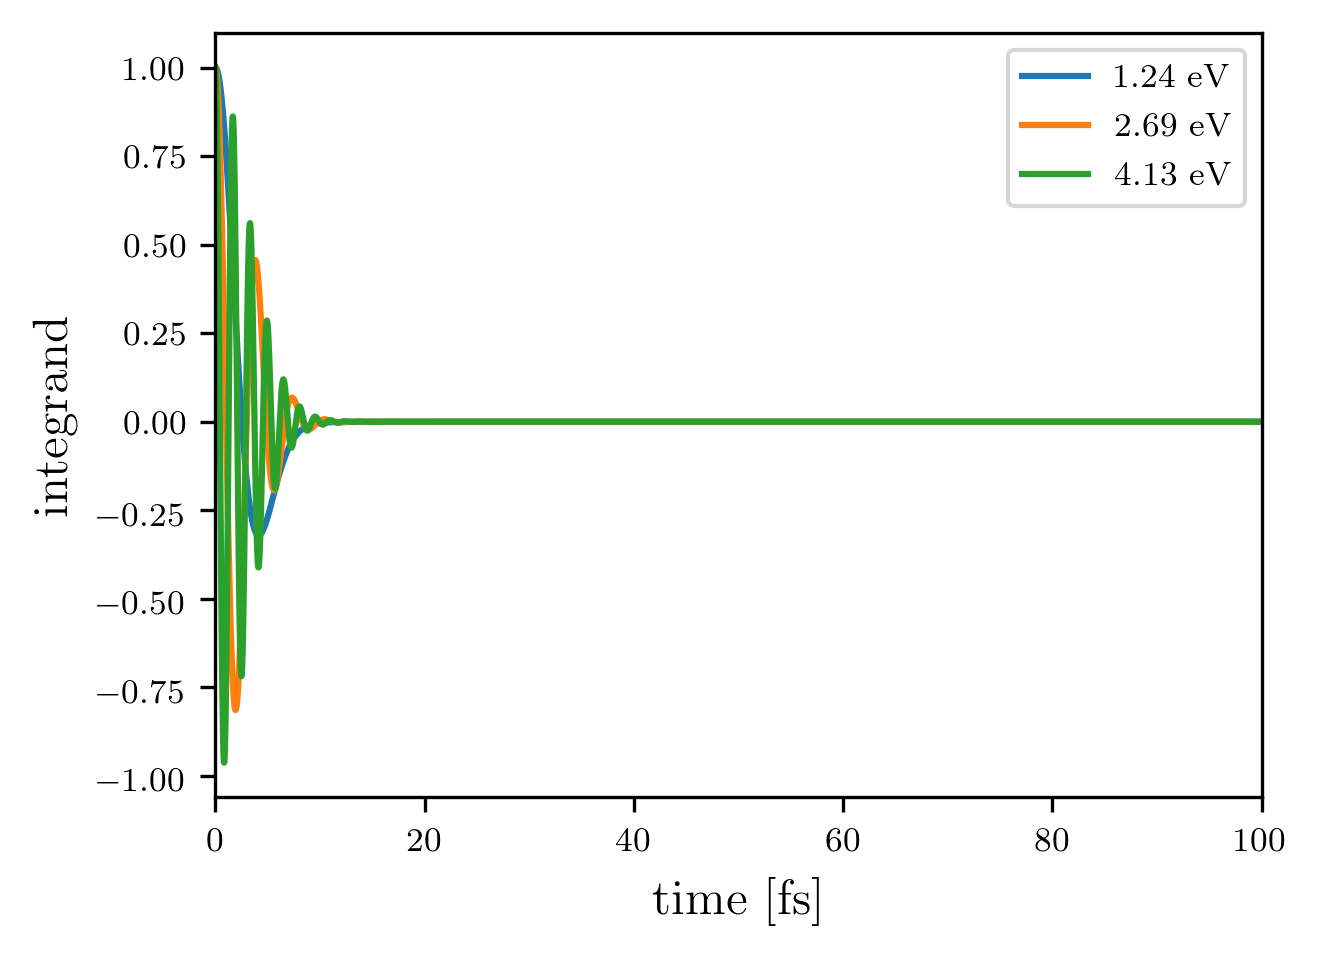

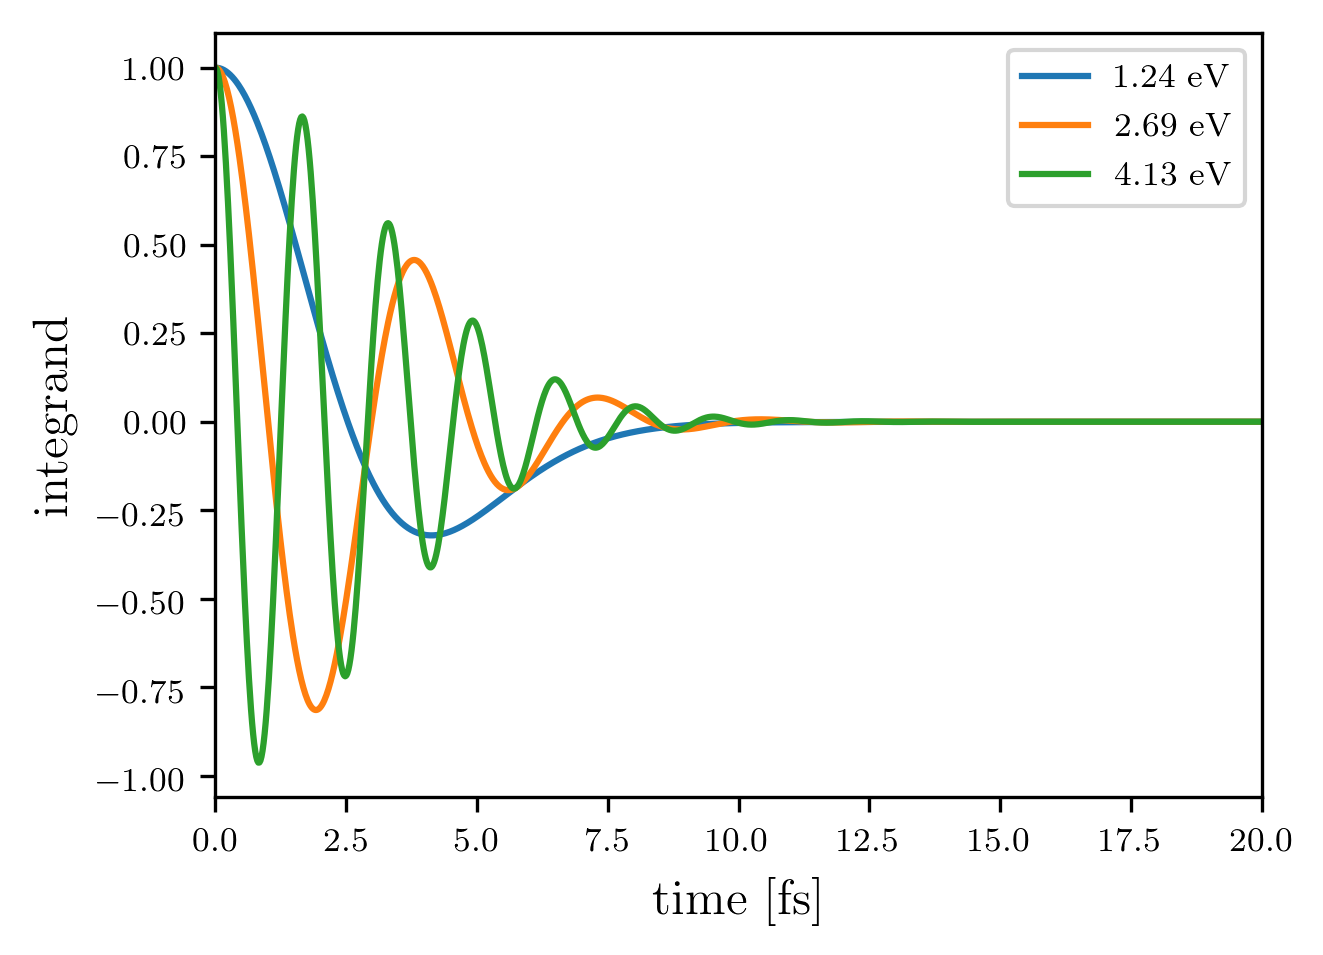

In [37]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 4
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .08
test_hbar_gamma = .03
test_t_bound = 200
test_t_points = 10000
test_T = 100

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]


plt.plot(
    1240/thermo_fisher_dye_data.T[0], 
    thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), 
    label='Emis. data'
    )
plt.plot(
    1240/thermo_fisher_dye_data.T[0], 
    thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), 
    label='Absorp. data'
    )


absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T#+150
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )

emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T#+150
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )

plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.3,2.75])


##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Plot function being integrated for emission on integration bounds
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
integrand_hbar_omegas = np.linspace(
    hbar_omegas.min(),
    hbar_omegas.max(),
    3)

integrand_t, emission_integrand = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    (
        integrand_hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
        -
        (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T,#+150
    return_integrand=True
    )

plt.figure()
for i, hw in enumerate(integrand_hbar_omegas):
    plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
plt.xlabel('time [fs]')
plt.ylabel('integrand')
plt.legend()

if integrand_t.max()>100:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,100])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

if integrand_t.max()>10:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,20])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

NameError: name 'sigma_a' is not defined

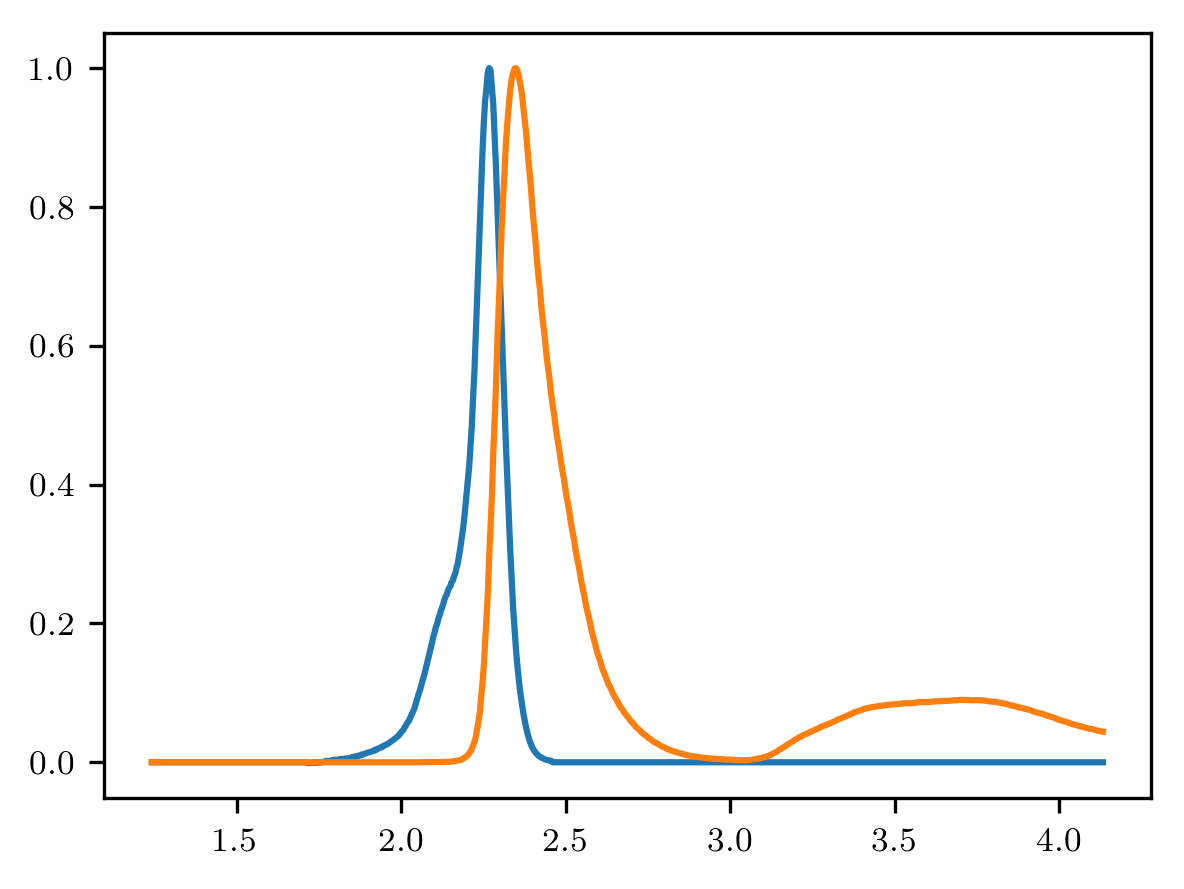

In [38]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 2
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .08
test_hbar_gamma = .005
test_t_bound = 1000
test_t_points = 1000
test_T = 10

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]


plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')


absorption =sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T#+150
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )

emission = sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T#+150
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )

plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.7,2.75])


##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Plot function being integrated for emission on integration bounds
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
integrand_hbar_omegas = np.linspace(
    hbar_omegas.min(),
    hbar_omegas.max(),
    3)

integrand_t, emission_integrand = sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    (
        integrand_hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
        -
        (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T,#+150
    return_integrand=True
    )

plt.figure()
plt.plot(integrand_t, emission_integrand.T)
plt.xlabel('time [fs]')
plt.ylabel('integrand')

if integrand_t.max()>100:
    plt.figure()
    plt.plot(integrand_t, emission_integrand.T)
    plt.xlim([0,100])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')

if integrand_t.max()>10:
    plt.figure()
    plt.plot(integrand_t, emission_integrand.T)
    plt.xlim([0,20])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')



In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 4
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .07
test_hbar_gamma = .005
test_t_bound = 1000
test_t_points = 10000
test_T = 100

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]


plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')


absorption =sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T#+150
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )

emission = sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T#+150
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )

plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.25,3.25])


##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Plot function being integrated for emission on integration bounds
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
integrand_hbar_omegas = np.linspace(
    hbar_omegas.min(),
    hbar_omegas.max(),
    3)

integrand_t, emission_integrand = sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    (
        integrand_hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
        -
        (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T,#+150
    return_integrand=True
    )

plt.figure()
plt.plot(integrand_t, emission_integrand.T)
plt.xlabel('time [fs]')
plt.ylabel('integrand')

if integrand_t.max()>100:
    plt.figure()
    plt.plot(integrand_t, emission_integrand.T)
    plt.xlim([0,100])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')

if integrand_t.max()>10:
    plt.figure()
    plt.plot(integrand_t, emission_integrand.T)
    plt.xlim([0,20])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')



Try mukamel numbers if I don't multiply by 2$\pi$

In [ ]:
600*c*hbar*2

In [ ]:
400*c*hbar*2

In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 4
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .0236
test_hbar_gamma = .0158
test_t_bound = 1000
test_t_points = 10000
test_T = 100

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]


plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')


absorption =sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T#+150
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )

emission = sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T#+150
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )

plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.25,3.25])


##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Plot function being integrated for emission on integration bounds
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
integrand_hbar_omegas = np.linspace(
    hbar_omegas.min(),
    hbar_omegas.max(),
    3)

integrand_t, emission_integrand = sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    (
        integrand_hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
        -
        (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T,#+150
    return_integrand=True
    )

plt.figure()
plt.plot(integrand_t, emission_integrand.T)
plt.xlabel('time [fs]')
plt.ylabel('integrand')

if integrand_t.max()>100:
    plt.figure()
    plt.plot(integrand_t, emission_integrand.T)
    plt.xlim([0,100])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')

if integrand_t.max()>10:
    plt.figure()
    plt.plot(integrand_t, emission_integrand.T)
    plt.xlim([0,20])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')



In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 4
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .0236
test_hbar_gamma = .0158
test_t_bound = 1000
test_t_points = 10000
test_T = 100

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]


plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')


absorption =sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
#             -
#             (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)
            ),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T#+150
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )

emission = sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            ),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T#+150
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )

plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.25,3.25])


##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Plot function being integrated for emission on integration bounds
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
integrand_hbar_omegas = np.linspace(
    hbar_omegas.min(),
    hbar_omegas.max(),
    3)

integrand_t, emission_integrand = sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    (
        integrand_hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
        ),
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T,#+150
    return_integrand=True
    )

plt.figure()
plt.plot(integrand_t, emission_integrand.T)
plt.xlabel('time [fs]')
plt.ylabel('integrand')

if integrand_t.max()>100:
    plt.figure()
    plt.plot(integrand_t, emission_integrand.T)
    plt.xlim([0,100])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')

if integrand_t.max()>10:
    plt.figure()
    plt.plot(integrand_t, emission_integrand.T)
    plt.xlim([0,20])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')



## Making plots to tell a story 03/24/20

In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = .8
test_hbar_omega_0 = .22
test_hbar_gamma = .15
test_t_bound = 1000
test_t_points = 10000
test_T = .0001

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.6,2.75])

In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = .8
test_hbar_omega_0 = .22
test_hbar_gamma = .15
test_t_bound = 1000
test_t_points = 10000
test_T = 300

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.6,2.75])

In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = .8
test_hbar_omega_0 = .22
test_hbar_gamma = .05
test_t_bound = 5*1000
test_t_points = 5*10000
test_T = 300

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.6,2.75])

In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.2
test_hbar_omega_0 = .17
test_hbar_gamma = .1
test_t_bound = 1000
test_t_points = 10000
test_T = 300

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.6,2.75])

In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.2
# test_hbar_omega_0 = hbar * invcmtohz(300)
# test_hbar_gamma = hbar * invcmtohz(400)
test_hbar_omega_0 = .17
test_hbar_gamma = .01
test_t_bound = 1000
test_t_points = 10000
test_T = 350

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.6,2.75])

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Plot function being integrated for emission on integration bounds
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
integrand_hbar_omegas = np.linspace(
    hbar_omegas.min(),
    hbar_omegas.max(),
    3)

integrand_t, emission_integrand = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    (
        integrand_hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
        -
        (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T,#+150
    return_integrand=True
    )

plt.figure()
for i, hw in enumerate(integrand_hbar_omegas):
    plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
plt.xlabel('time [fs]')
plt.ylabel('integrand')
plt.legend()

if integrand_t.max()>100:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,100])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

if integrand_t.max()>10:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,20])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.4
test_hbar_omega_0 = .08
test_hbar_gamma = .003
test_t_bound = 1000*2
test_t_points = 10000*2
test_T = 350

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.6,2.75])

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Plot function being integrated for emission on integration bounds
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
integrand_hbar_omegas = np.linspace(
    hbar_omegas.min(),
    hbar_omegas.max(),
    3)

integrand_t, emission_integrand = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    (
        integrand_hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
        -
        (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T,#+150
    return_integrand=True
    )

plt.figure()
for i, hw in enumerate(integrand_hbar_omegas):
    plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
plt.xlabel('time [fs]')
plt.ylabel('integrand')
plt.legend()

if integrand_t.max()>100:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,100])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

if integrand_t.max()>10:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,20])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.4
test_hbar_omega_0 = .07
test_hbar_gamma = .007
test_t_bound = 1000
test_t_points = 10000
test_T = 300

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.6,2.75])

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Plot function being integrated for emission on integration bounds
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
integrand_hbar_omegas = np.linspace(
    hbar_omegas.min(),
    hbar_omegas.max(),
    3)

integrand_t, emission_integrand = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    (
        integrand_hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
        -
        (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T,#+150
    return_integrand=True
    )

plt.figure()
for i, hw in enumerate(integrand_hbar_omegas):
    plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
plt.xlabel('time [fs]')
plt.ylabel('integrand')
plt.legend()

if integrand_t.max()>100:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,100])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

if integrand_t.max()>10:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,20])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.4
test_hbar_omega_0 = .07
test_hbar_gamma = .07
test_t_bound = 1000
test_t_points = 10000
test_T = 300

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot( 
    1240/thermo_fisher_dye_data.T[0], 
    thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), 
    label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )


## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')


## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )


plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.6,2.75])

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Plot function being integrated for emission on integration bounds
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
integrand_hbar_omegas = np.linspace(
    hbar_omegas.min(),
    hbar_omegas.max(),
    3)

integrand_t, emission_integrand = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    (
        integrand_hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
        -
        (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T,#+150
    return_integrand=True
    )

plt.figure()
for i, hw in enumerate(integrand_hbar_omegas):
    plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
plt.xlabel('time [fs]')
plt.ylabel('integrand')
plt.legend()

if integrand_t.max()>100:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,100])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

if integrand_t.max()>10:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,20])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.2
test_hbar_omega_0 = 0.074
test_hbar_gamma = 0.0049593
test_t_bound = 1000
test_t_points = 10000
test_T = 500

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(
    1240/thermo_fisher_dye_data.T[0], 
    thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), 
    label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.6,2.75])

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Plot function being integrated for emission on integration bounds
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
integrand_hbar_omegas = np.linspace(
    hbar_omegas.min(),
    hbar_omegas.max(),
    3)

integrand_t, emission_integrand = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    (
        integrand_hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
        -
        (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T,#+150
    return_integrand=True
    )

plt.figure()
for i, hw in enumerate(integrand_hbar_omegas):
    plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
plt.xlabel('time [fs]')
plt.ylabel('integrand')
plt.legend()

if integrand_t.max()>100:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,100])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

if integrand_t.max()>10:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,20])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

In [ ]:
dom.invcmtohz(400)*hbar

In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.2
test_hbar_omega_0 = 0.074
test_hbar_gamma = 0.049593678955041146
test_t_bound = 1000
test_t_points = 10000
test_T = 50

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot(
    1240/thermo_fisher_dye_data.T[0], 
    thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), 
    label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )



## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')



## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )




plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.6,2.75])

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Plot function being integrated for emission on integration bounds
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
integrand_hbar_omegas = np.linspace(
    hbar_omegas.min(),
    hbar_omegas.max(),
    3)

integrand_t, emission_integrand = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    (
        integrand_hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
        -
        (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T,#+150
    return_integrand=True
    )

plt.figure()
for i, hw in enumerate(integrand_hbar_omegas):
    plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
plt.xlabel('time [fs]')
plt.ylabel('integrand')
plt.legend()

if integrand_t.max()>100:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,100])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

if integrand_t.max()>10:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,20])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

## Wednesday March 25

In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.6
test_hbar_omega_0 = .03
test_hbar_gamma = .015
test_t_bound = 1000
test_t_points = 10000
test_T = 300

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot( 
    1240/thermo_fisher_dye_data.T[0], 
    thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), 
    label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--', 
    label='Emis. model'
    )


## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')


## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--', 
    label='Absorp. model'
    )


plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.6,2.75])

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Plot function being integrated for emission on integration bounds
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
integrand_hbar_omegas = np.linspace(
    hbar_omegas.min(),
    hbar_omegas.max(),
    3)

integrand_t, emission_integrand = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    (
        integrand_hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
        -
        (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T,#+150
    return_integrand=True
    )

plt.figure()
for i, hw in enumerate(integrand_hbar_omegas):
    plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
plt.xlabel('time [fs]')
plt.ylabel('integrand')
plt.legend()

if integrand_t.max()>100:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,100])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

if integrand_t.max()>10:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,20])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

In [ ]:
test_hbar_omega_eg_0 = 2.3
test_script_d = 1.6
test_hbar_omega_0 = .03
test_hbar_gamma = .0015
test_t_bound = 1000
test_t_points = 10000
test_T = 300

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

## Plot emission data 
plt.plot( 
    1240/thermo_fisher_dye_data.T[0], 
    thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max(), 
    label='Emis. data')

## Build emission model 
emission = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )

plt.plot(
    hbar_omegas, 
    emission/emission.max(),
    ls='--',
    lw=1,
    label='Emis. model'
    )


## Plot Absorption Data
plt.plot(1240/thermo_fisher_dye_data.T[0], thermo_fisher_dye_data.T[1]/thermo_fisher_dye_data.T[1].max(), label='Absorp. data')


## Build abs model
absorption = dom.sigma_a(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
        (
            hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
            -
            (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
        script_d=test_script_d, 
        omega_q=test_hbar_omega_0/hbar,
        gamma=test_hbar_gamma/hbar,
        t_bound=test_t_bound, 
        t_points=test_t_points,
        T = test_T
        )


plt.plot(
    hbar_omegas, 
    absorption/absorption.max(),
    ls='--',
    lw=1,
    label='Absorp. model'
    )


plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)
plt.ylabel('Normalized Intensity', fontsize=10)
plt.legend()

plt.xlim([1.6,2.75])

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Plot function being integrated for emission on integration bounds
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
integrand_hbar_omegas = np.linspace(
    hbar_omegas.min(),
    hbar_omegas.max(),
    3)

integrand_t, emission_integrand = dom.sigma_e(
#         (omegas-(1/2*test_script_d**2.*test_hbar_omega_0/hbar)), 
    (
        integrand_hbar_omegas/hbar - test_hbar_omega_eg_0/hbar
        -
        (1/2 * test_script_d**2. * test_hbar_omega_0/hbar)),
    script_d=test_script_d, 
    omega_q=test_hbar_omega_0/hbar,
    gamma=test_hbar_gamma/hbar,
    t_bound=test_t_bound, 
    t_points=test_t_points,
    T = test_T,#+150
    return_integrand=True
    )

plt.figure()
for i, hw in enumerate(integrand_hbar_omegas):
    plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
plt.xlabel('time [fs]')
plt.ylabel('integrand')
plt.legend()

if integrand_t.max()>100:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,100])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()

if integrand_t.max()>10:
    plt.figure()
    for i, hw in enumerate(integrand_hbar_omegas):
        plt.plot(integrand_t, emission_integrand[i], label=f'{hw:.2f} eV')
    plt.xlim([0,20])
    plt.xlabel('time [fs]')
    plt.ylabel('integrand')
    plt.legend()